In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [ ]:
# Import data
data = pd.read_csv('/content/drive/MyDrive/per_game_data(1).csv')
data.head()

# Getting names to the columns
col_names = data.columns
col_names = list(col_names)

# Getting a subset of data to train the model
train = data.sample(1000)

# Data we are trying to predict on
newest_players = data[data['Year'] == 2024]

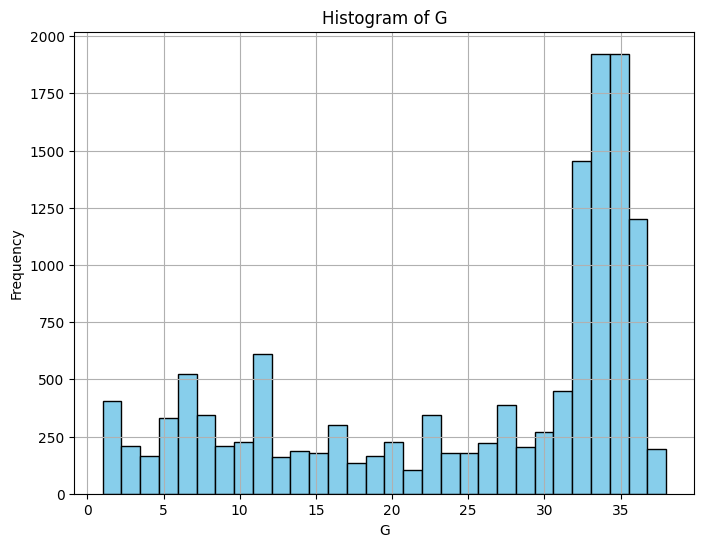

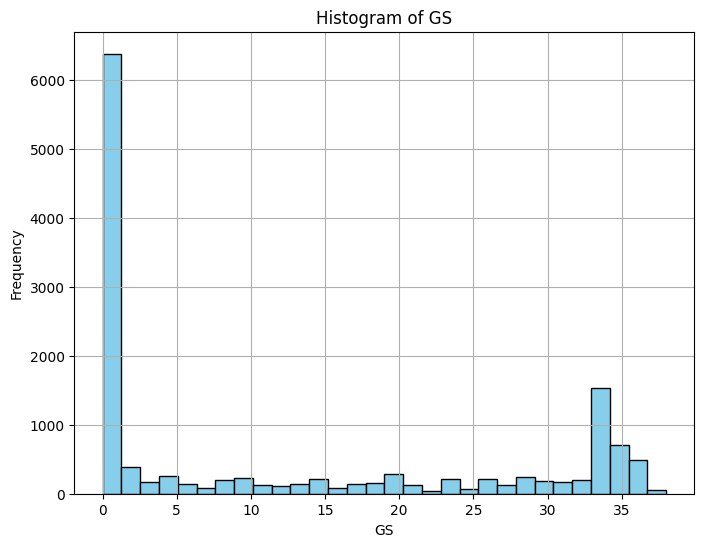

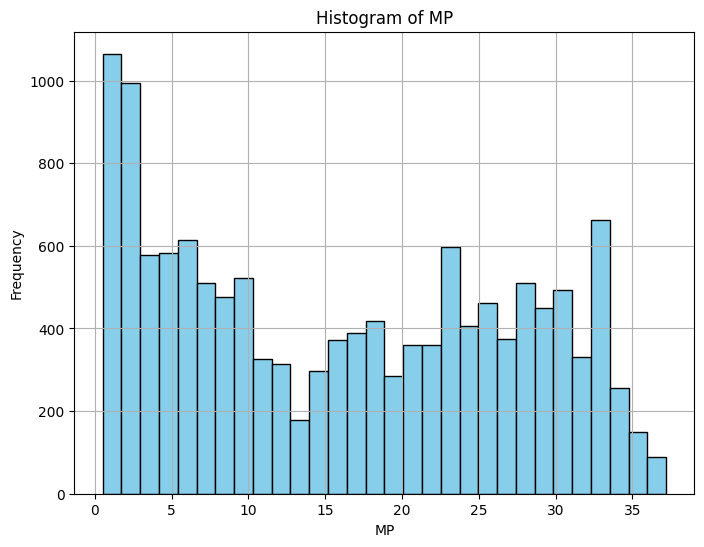

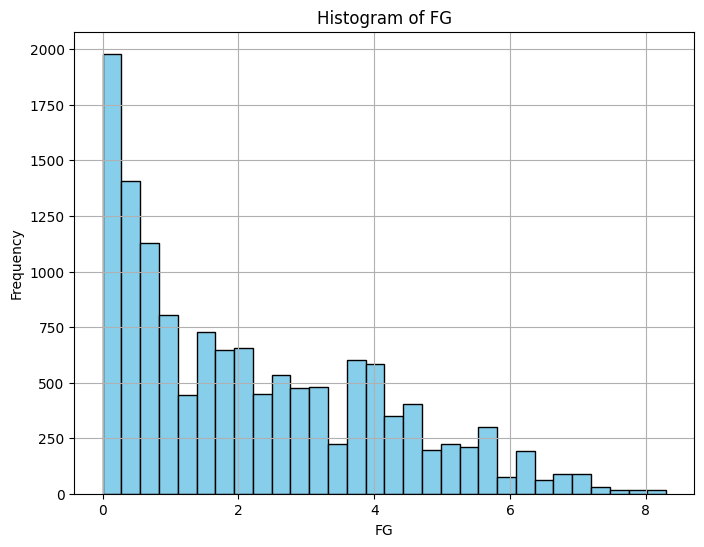

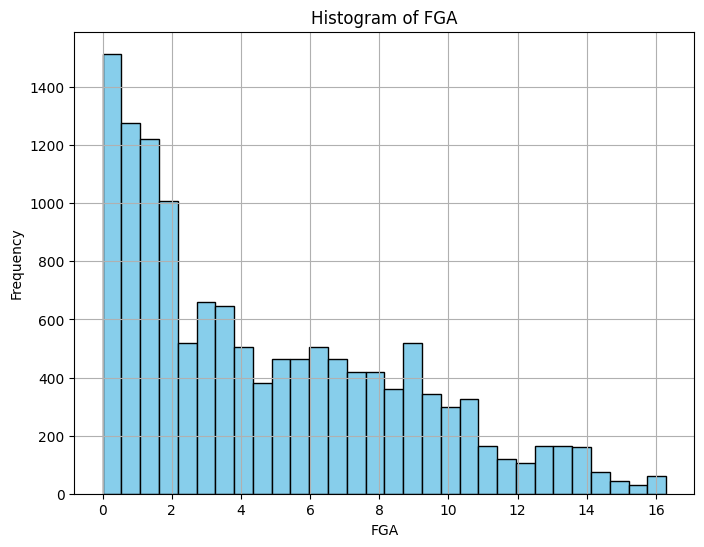

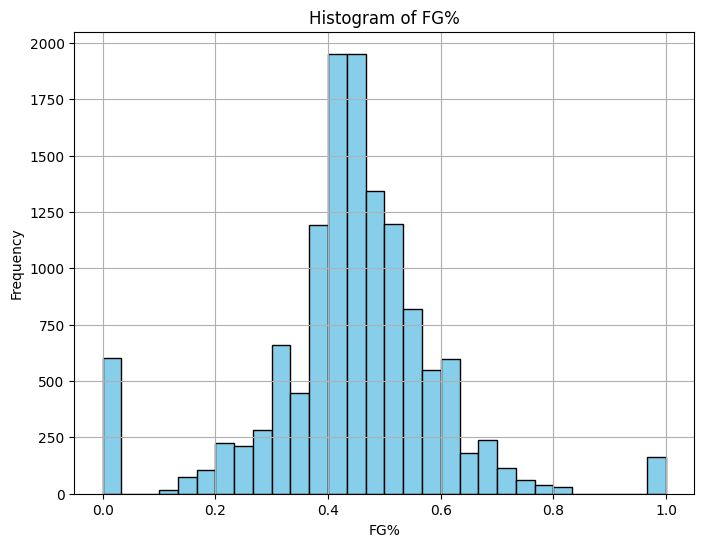

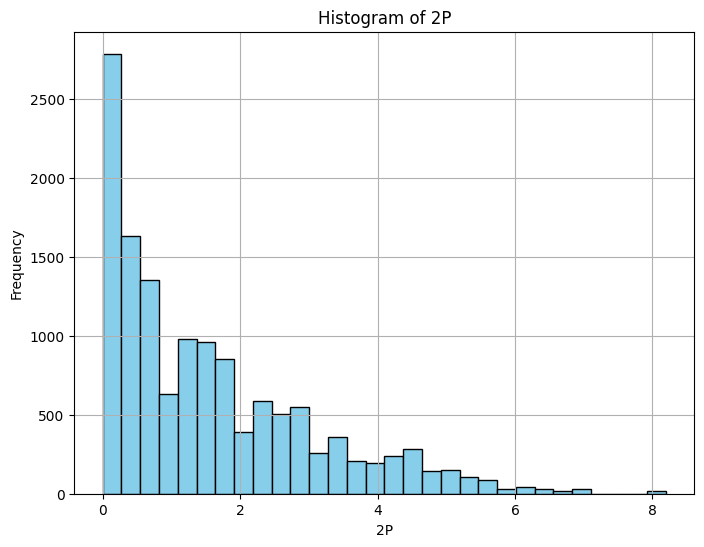

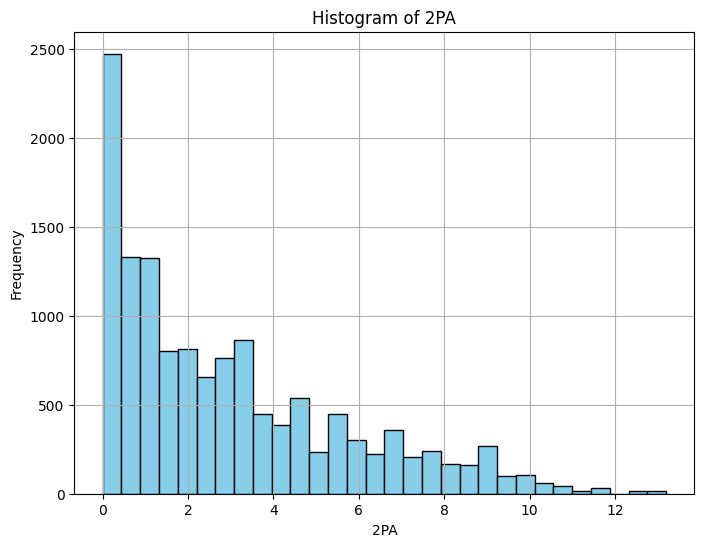

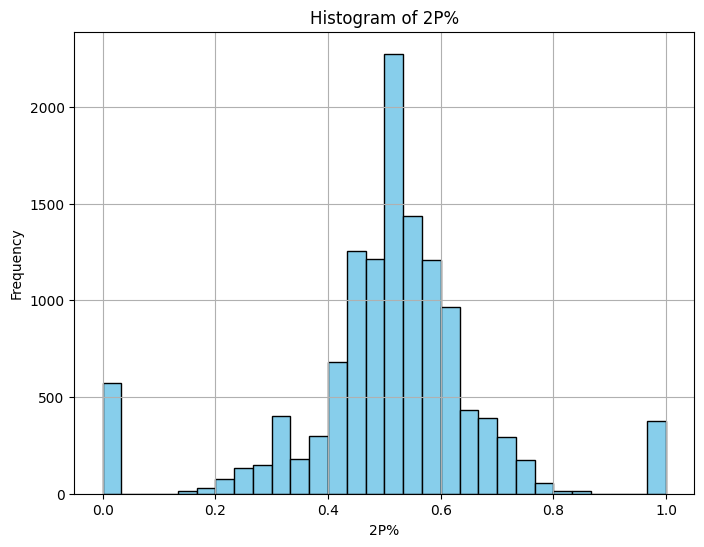

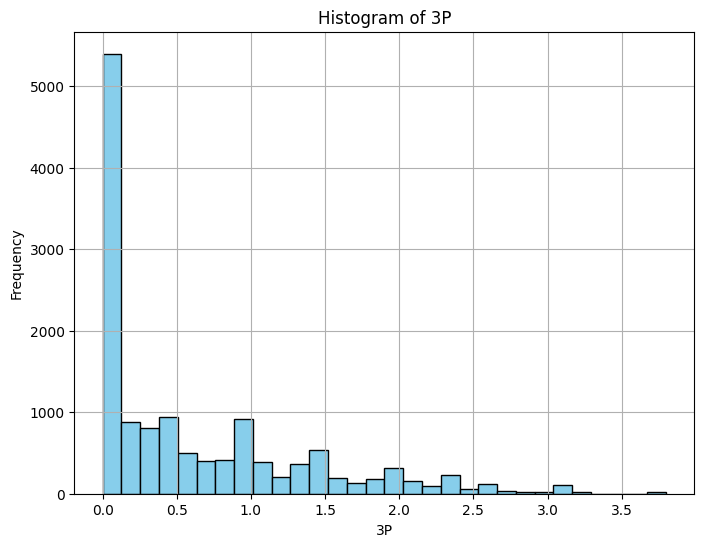

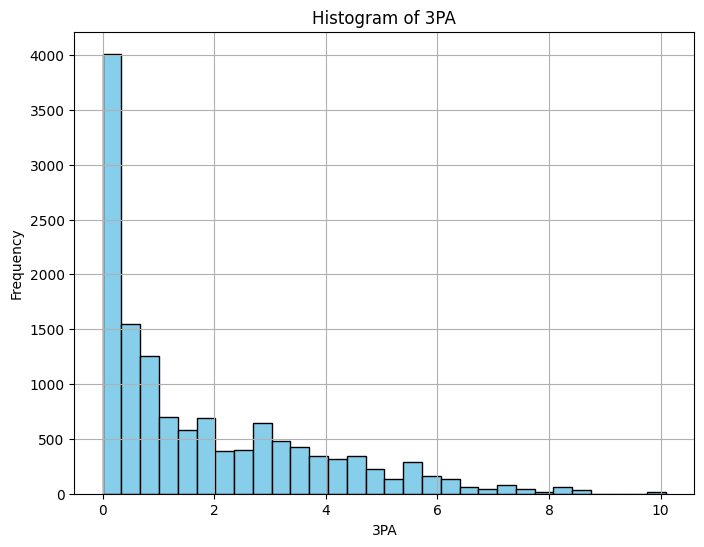

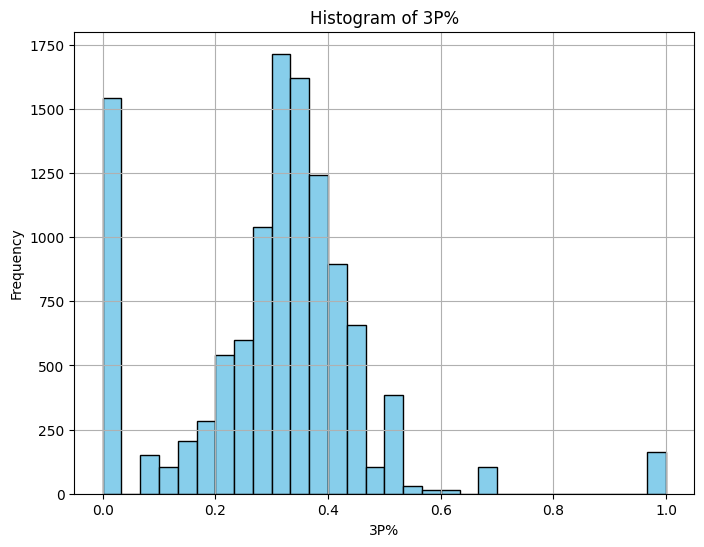

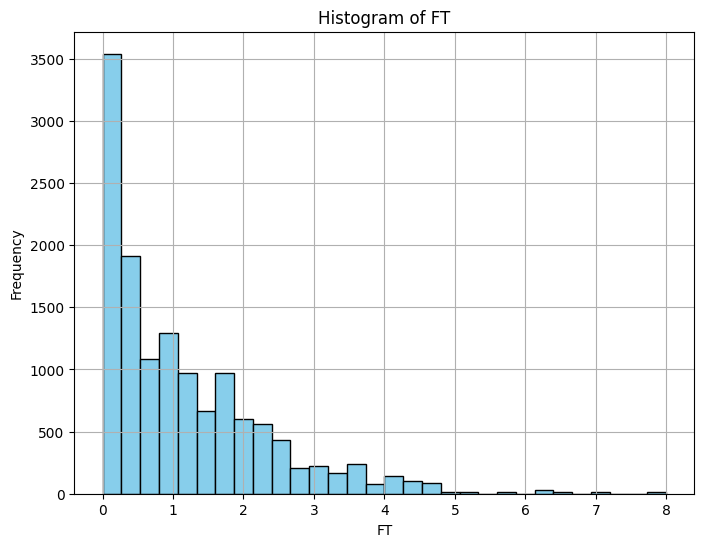

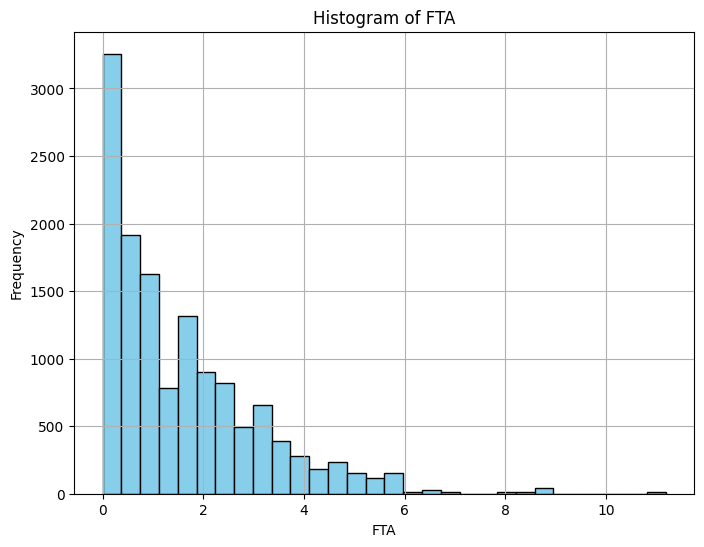

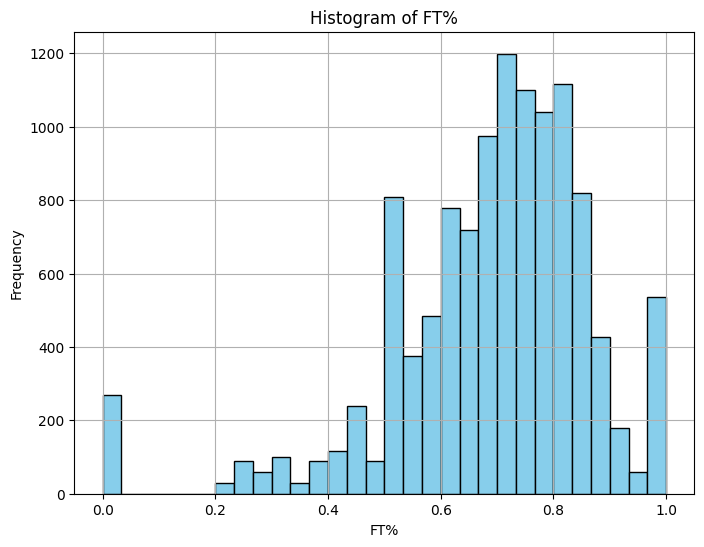

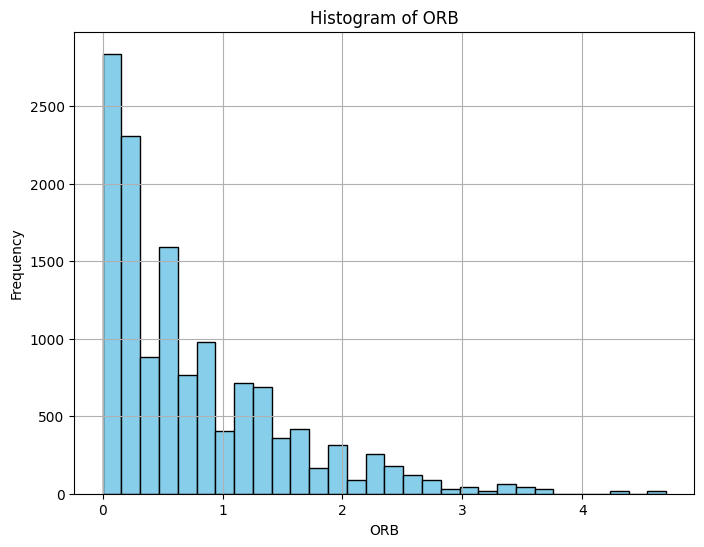

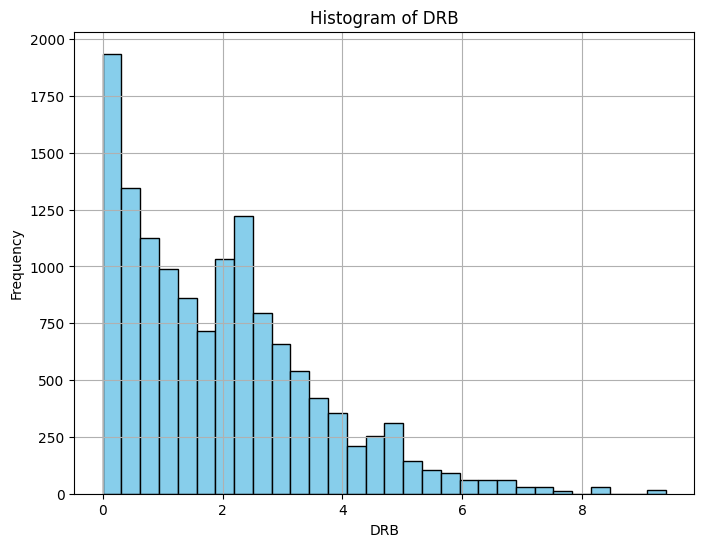

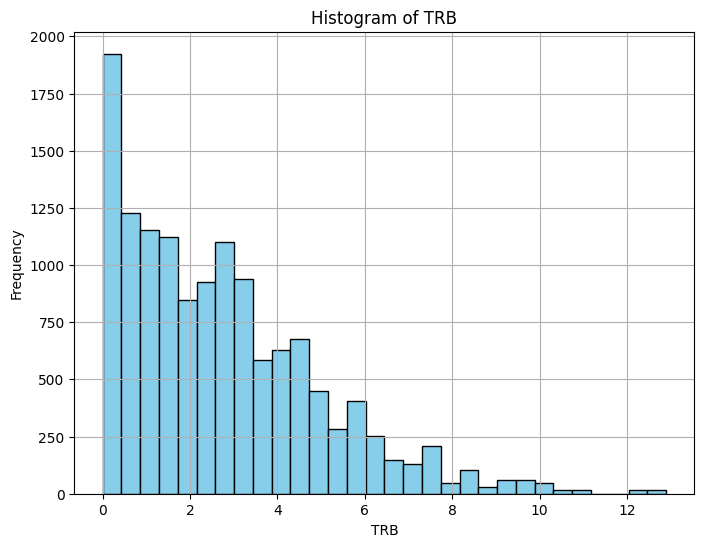

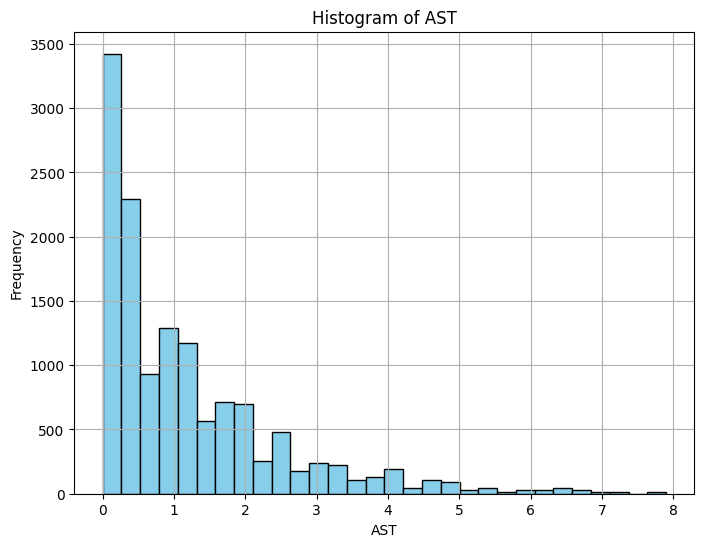

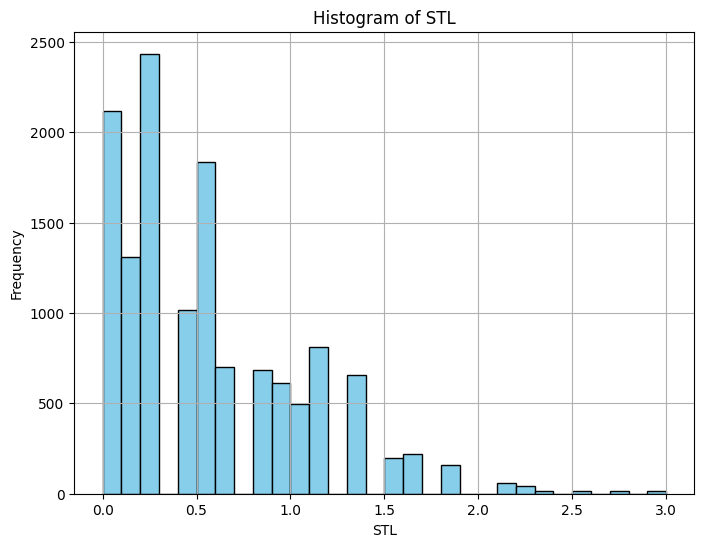

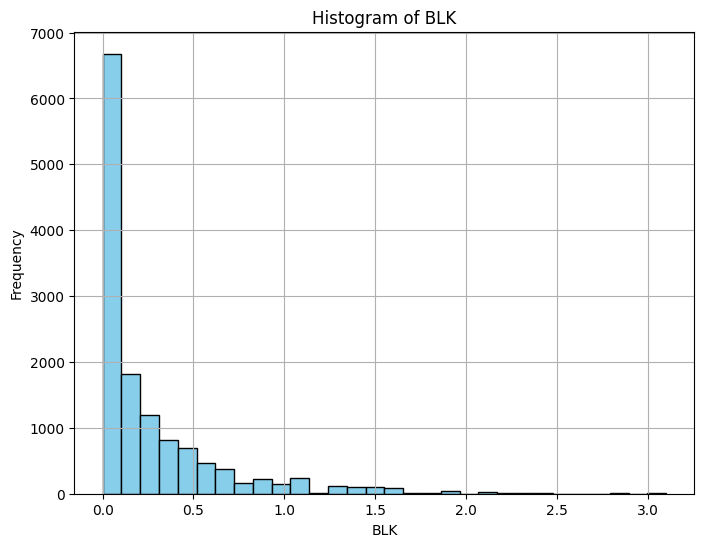

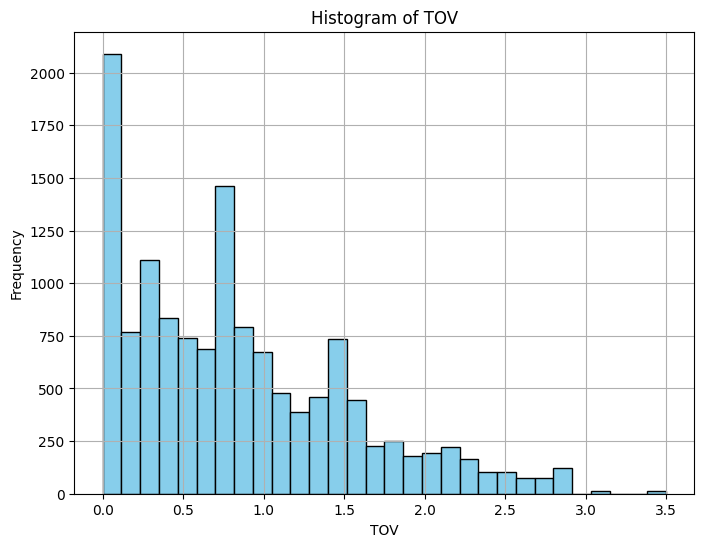

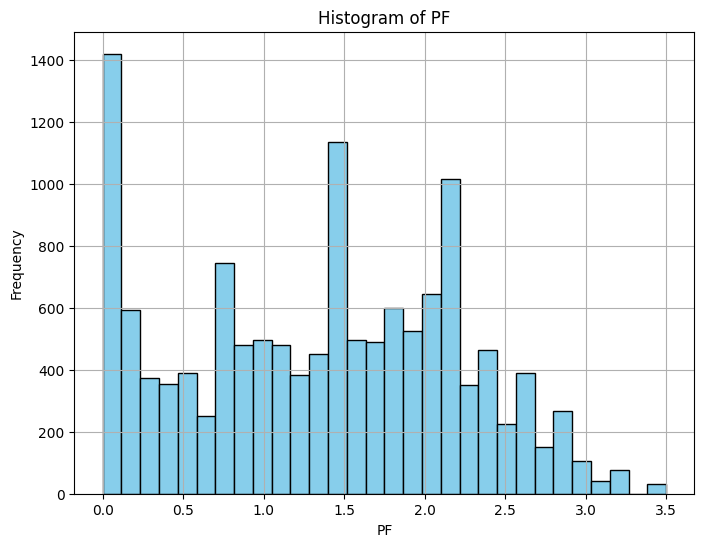

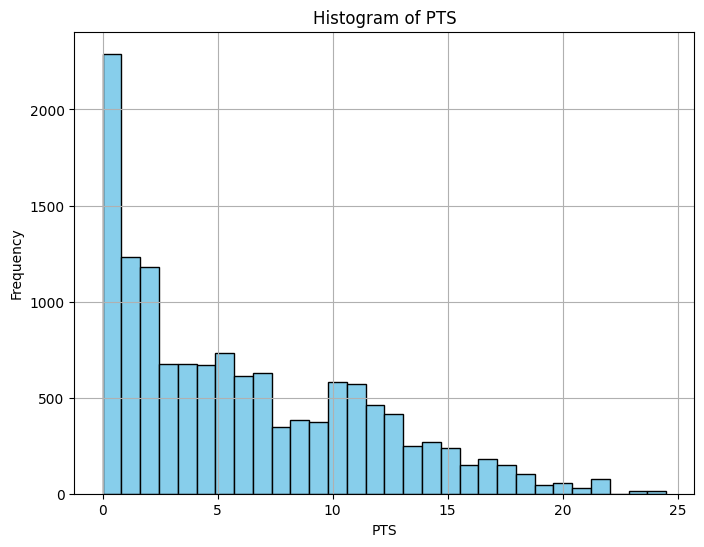

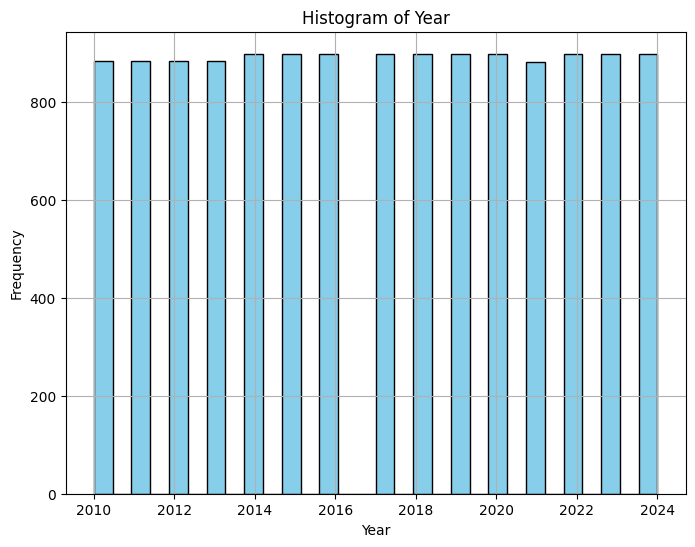

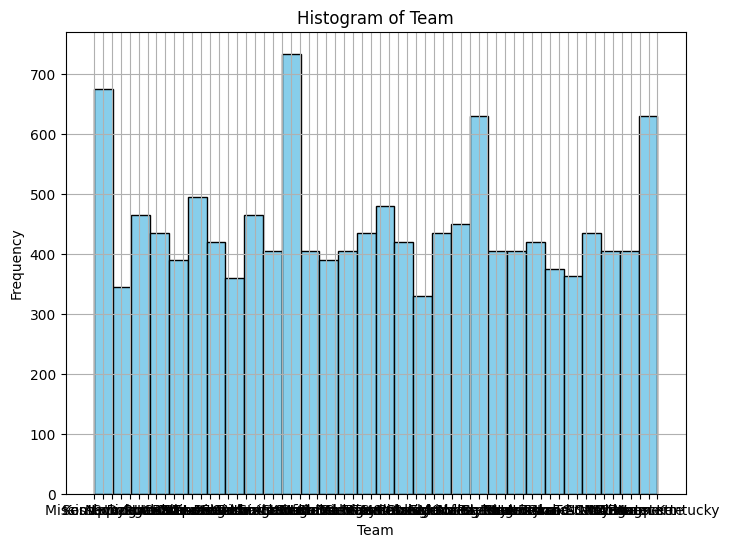

In [ ]:
# Examine each variable

def plot_histograms(col_names):
    for column in col_names:
        plt.figure(figsize=(8, 6))
        plt.hist(data[str(column)], bins=30, color='skyblue', edgecolor='black')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

plot_histograms(col_names[3:])

In [ ]:
# Look at correlation of the variables with our response
correlation = data.corr()
PTS_corr = correlation['PTS']
PTS_corr

<ipython-input-5-632fe8251d16>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


Unnamed: 0    0.007013
Rk           -0.923544
G             0.641885
GS            0.836392
MP            0.919595
FG            0.990300
FGA           0.980609
FG%           0.248204
2P            0.885836
2PA           0.911235
2P%           0.133436
3P            0.709842
3PA           0.709868
3P%           0.283488
FT            0.910692
FTA           0.890227
FT%           0.358127
ORB           0.531776
DRB           0.816722
TRB           0.766176
AST           0.697791
STL           0.735374
BLK           0.437983
TOV           0.844923
PF            0.708716
PTS           1.000000
Year          0.000160
Name: PTS, dtype: float64

In [ ]:
# Setting a set of predictors based on their correlation with the response and previous knowledge
pred = ['GS', 'MP', 'FGA', '2PA', '3PA', 'FTA', 'DRB', 'TOV']
all_pred = ['GS', 'MP', 'FGA', '2PA', '3PA', 'FTA', 'DRB', 'TOV', 'PTS']

In [ ]:
X = train[all_pred]
Y = train[['PTS']]

X = X.reset_index(drop = 'index')
Y = Y.reset_index(drop = 'index')

mean = np.mean(X)
std = np.std(X)

# normalize X
X = (X - np.mean(X)) / np.std(X)
Y = (Y - np.mean(Y)) / np.std(Y)

n,p=X.shape[0],9

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
# MLR with multi-variate normal on the betas
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p, 1)), cov=np.eye(p), shape=(p, 1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.MvNormal('y', mu=pm.math.dot(X, betas), cov=np.eye(p), observed=Y)

mu.eval()

with MLR:
    A = pm.sample()

In [ ]:
with pm.Model() as model:
    obs = pm.MutableData("obs", X)
    Y = pm.MutableData("Y", Y)

    # LKJ prior on Cov
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.HalfCauchy.dist(beta = 1), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)

    # MVN on betas
    betas = pm.MvNormal('betas', mu=np.zeros((p, 9)), chol = L)

    # Normal for y
    y = pm.MvNormal('y', mu=pm.math.dot(obs, betas), cov=np.eye(p), observed=Y)

with model:
  trace = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (127) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'betas\n0, 0'}>,
        <Axes: title={'center': 'betas\n0, 1'}>,
        <Axes: title={'center': 'betas\n0, 2'}>,
        <Axes: title={'center': 'betas\n0, 3'}>],
       [<Axes: title={'center': 'betas\n0, 4'}>,
        <Axes: title={'center': 'betas\n0, 5'}>,
        <Axes: title={'center': 'betas\n0, 6'}>,
        <Axes: title={'center': 'betas\n0, 7'}>],
       [<Axes: title={'center': 'betas\n0, 8'}>,
        <Axes: title={'center': 'betas\n1, 0'}>,
        <Axes: title={'center': 'betas\n1, 1'}>,
        <Axes: title={'center': 'betas\n1, 2'}>],
       [<Axes: title={'center': 'betas\n1, 3'}>,
        <Axes: title={'center': 'betas\n1, 4'}>,
        <Axes: title={'center': 'betas\n1, 5'}>,
        <Axes: title={'center': 'betas\n1, 6'}>],
       [<Axes: title={'center': 'betas\n1, 7'}>,
        <Axes: title={'center': 'betas\n1, 8'}>,
        <Axes: title={'center': 'betas\n2, 0'}>,
        <Axes: title={'center': 'betas\n2, 1'}>],
       [<Axes: 

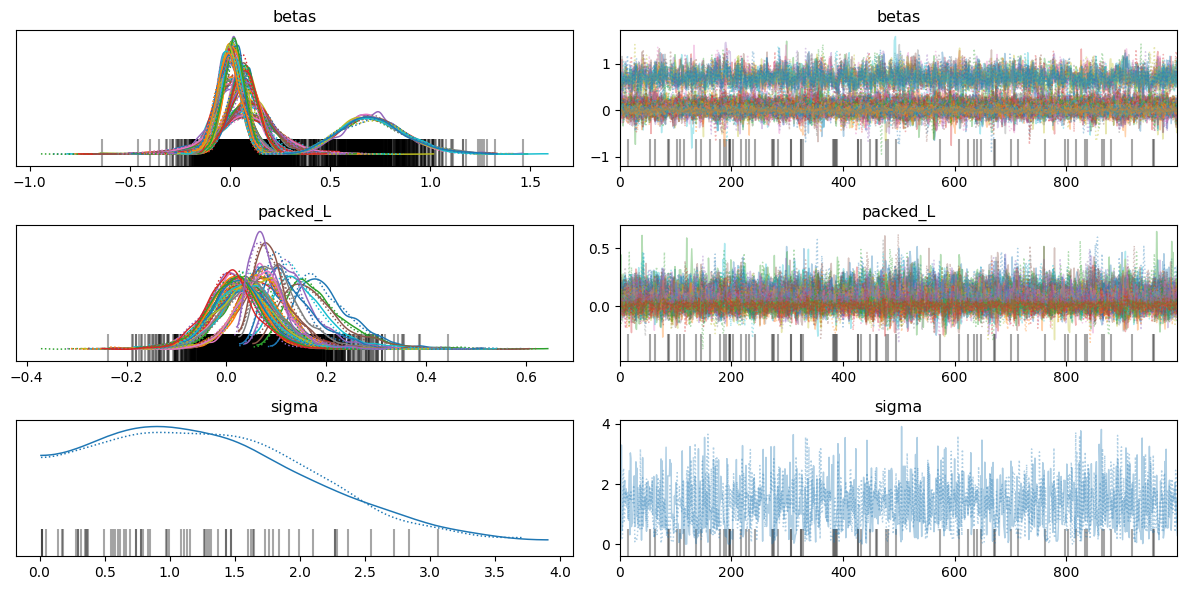

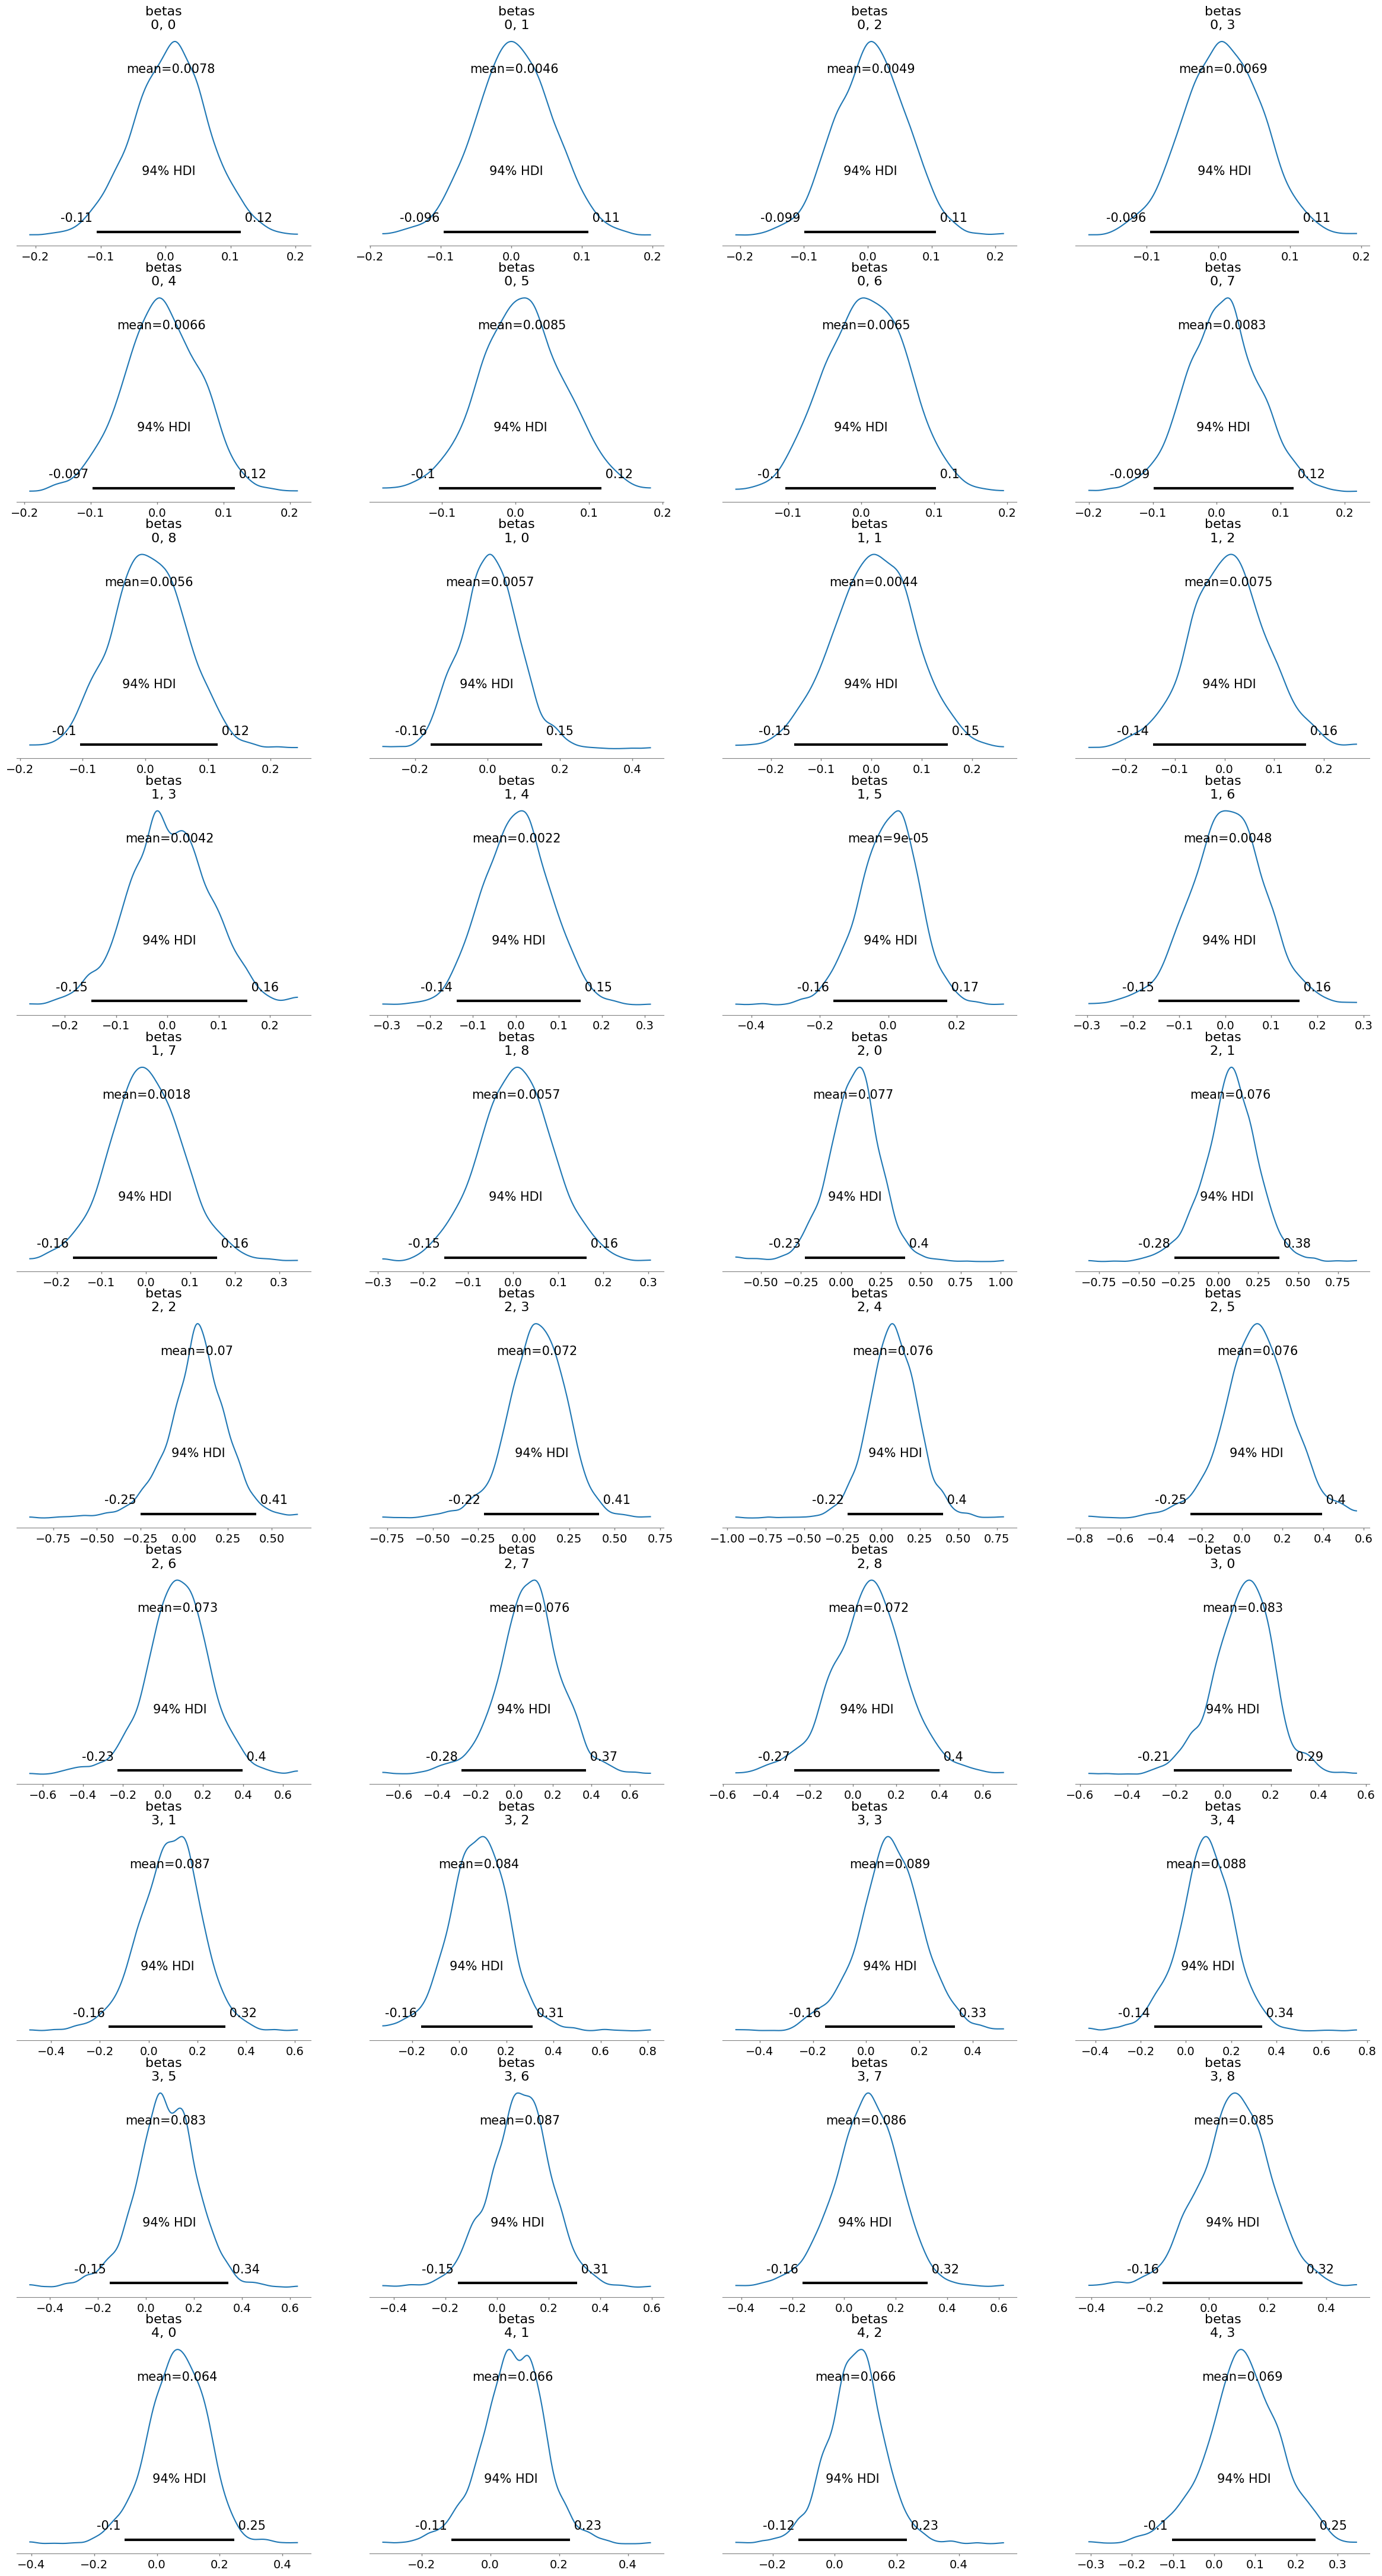

In [ ]:
# Trace plots
az.plot_trace(trace)
plt.tight_layout()
az.plot_posterior(trace)

In [ ]:
# For prediction
newest_players = data[data['Year'] == 2024]
newest_players

X = newest_players[all_pred]
Y = newest_players[['PTS']]

In [ ]:
meanp = np.mean(X)
stdp = np.std(X)

# normalize X and Y
X = (X - np.mean(X)) / np.std(X)
Y = (Y - np.mean(Y)) / np.std(Y)

normalized_df = pd.DataFrame(X)
normalized_df = normalized_df.reset_index(drop = 'index')
normalized_y = pd.DataFrame(Y)
normalized_y = normalized_y.reset_index(drop = 'index')

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
with model:
    pm.set_data(new_data={"obs": normalized_df})
    posterior_samples = pm.sample_posterior_predictive(trace)


In [ ]:
expected_betas = posterior_samples.posterior_predictive["y"].mean(("chain", "draw"))
expected_betas = pd.DataFrame(expected_betas, columns = all_pred)
expected_betas['PTS'] = expected_betas['PTS'] * stdp[8] + meanp[8]
expected_betas = expected_betas.abs()

final = newest_players.reset_index(drop='index')[['Player', 'Team']].join(expected_betas)
final
# final.to_csv('NEW_posterior_samples_mvn.csv')


,Player,Team,GS,MP,FGA,2PA,3PA,FTA,DRB,TOV,PTS
0,Antonio Reeves,Kentucky,2.528629,2.520739,2.466251,2.476769,2.484797,2.499987,2.491569,2.510554,19.488912
1,Rob Dillingham,Kentucky,1.571002,1.597428,1.609558,1.598866,1.624886,1.635731,1.593869,1.596046,14.716311
2,Reed Sheppard,Kentucky,1.030834,1.100973,1.055305,1.097404,1.045579,1.080067,1.043743,1.065957,11.627110
3,Tre Mitchell,Kentucky,0.880174,0.901664,0.893966,0.894162,0.930391,0.867852,0.880332,0.902543,10.711436
4,D.J. Wagner,Kentucky,0.763962,0.747620,0.751274,0.752716,0.707104,0.749434,0.726065,0.758556,9.975545
...,...,...,...,...,...,...,...,...,...,...,...
894,Jaylen Dorsey,Western Kentucky,0.935926,0.960805,0.929884,0.915872,0.917463,0.924344,0.916322,0.908343,1.323743
895,Fallou Diagne,Western Kentucky,0.922145,0.943154,0.924669,0.936794,1.020131,0.913358,0.950425,0.905119,0.998132
896,Jack Edelen,Western Kentucky,0.927808,0.944756,0.969378,0.959808,0.973281,0.976655,0.934287,0.928675,1.008023
897,Tyler Olden,Western Kentucky,1.023482,1.015936,1.018942,0.960105,1.004412,0.988634,0.995800,1.057700,0.921028


In [ ]:
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(trace).items()}, end=' | ');

#since all Split-Rhat under 1.05, both chain converge

#effective sample size
az.summary(trace, round_to=2)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'betas': array([[1.0001, 1.0022, 1.0001, 1.0032, 1.001 , 1.0004, 1.0016, 1.0003,
        1.0043],
       [1.0006, 1.0028, 1.0023, 1.0019, 1.0025, 1.0002, 1.0021, 1.0023,
        1.    ],
       [1.0019, 1.0016, 1.0013, 1.0016, 0.9998, 1.0025, 1.0026, 1.0027,
        1.0035],
       [1.0002, 1.0027, 1.0005, 1.0031, 1.0023, 1.0027, 1.0013, 1.001 ,
        1.0063],
       [1.0005, 1.001 , 1.0009, 1.0047, 0.9999, 1.0033, 1.0009, 1.0022,
        1.003 ],
       [1.0042, 1.0023, 1.0046, 1.0035, 1.0014, 1.0014, 0.9998, 1.0004,
        1.0029],
       [1.0006, 1.0004, 1.0005, 1.002 , 0.9994, 1.0023, 1.0009, 0.9999,
        1.0019],
       [1.0031, 1.0002, 1.0017, 1.0019, 1.0018, 1.0001, 0.9994, 1.0103,
        1.0029],
       [1.0032, 1.0001, 1.0045, 1.005 , 1.0021, 1.0029, 1.0007, 1.001 ,
        0.9993]]), 'packed_L': array([1.0009, 1.0037, 1.0003, 1.0041, 1.0046, 1.0043, 1.0006, 1.0005,
       1.0002, 1.0026, 1.0016, 1.001 , 1.0017, 1.0002, 1.0002, 1.002 ,
       1.0007, 1.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.01,0.06,-0.11,0.12,0.00,0.00,2164.70,1344.46,1.0
"betas[0, 1]",0.00,0.06,-0.10,0.11,0.00,0.00,1978.01,1582.48,1.0
"betas[0, 2]",0.00,0.06,-0.10,0.11,0.00,0.00,2003.65,1636.29,1.0
"betas[0, 3]",0.01,0.06,-0.10,0.11,0.00,0.00,1771.25,1394.04,1.0
"betas[0, 4]",0.01,0.06,-0.10,0.12,0.00,0.00,2002.15,1216.55,1.0
...,...,...,...,...,...,...,...,...,...
packed_L[41],0.02,0.06,-0.10,0.11,0.00,0.00,1425.92,1223.81,1.0
packed_L[42],0.01,0.06,-0.10,0.13,0.00,0.00,1298.35,1089.93,1.0
packed_L[43],0.01,0.05,-0.09,0.12,0.00,0.00,1042.06,720.59,1.0
packed_L[44],0.09,0.04,0.02,0.16,0.00,0.00,631.25,980.22,1.0


In [ ]:
Psi=np.eye(p)
a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
# obs = X

# MLR with LKJ prior on the Cov and Multi-variate normal on the betas
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.HalfCauchy.dist(beta = 1), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    mu = pm.MvNormal('mu', mu=np.array(0), cov=np.eye(p), shape=p);
    obs = pm.Data("obs", X, mutable=False);
    y = pm.MvNormal('betas', mu=mu, chol=L, shape=(n,1), observed=obs);

with MNV_LKJ:
  idata = pm.sample()


/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


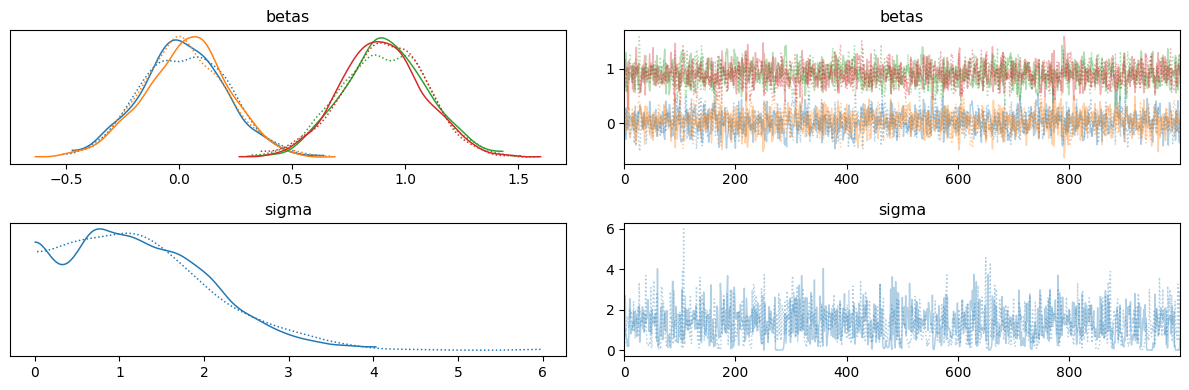

In [ ]:
# Trace plots
az.plot_trace(A)
plt.tight_layout()

In [ ]:
print(idata.posterior)

<xarray.Dataset>
Dimensions:         (chain: 2, draw: 1000, mu_dim_0: 3, packed_L_dim_0: 6)
Coordinates:
  * chain           (chain) int64 0 1
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * mu_dim_0        (mu_dim_0) int64 0 1 2
  * packed_L_dim_0  (packed_L_dim_0) int64 0 1 2 3 4 5
Data variables:
    mu              (chain, draw, mu_dim_0) float64 -0.008173 ... -0.00524
    packed_L        (chain, draw, packed_L_dim_0) float64 1.013 ... 0.3818
Attributes:
    created_at:                 2024-04-01T21:44:18.269066
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              101.01264548301697
    tuning_steps:               1000


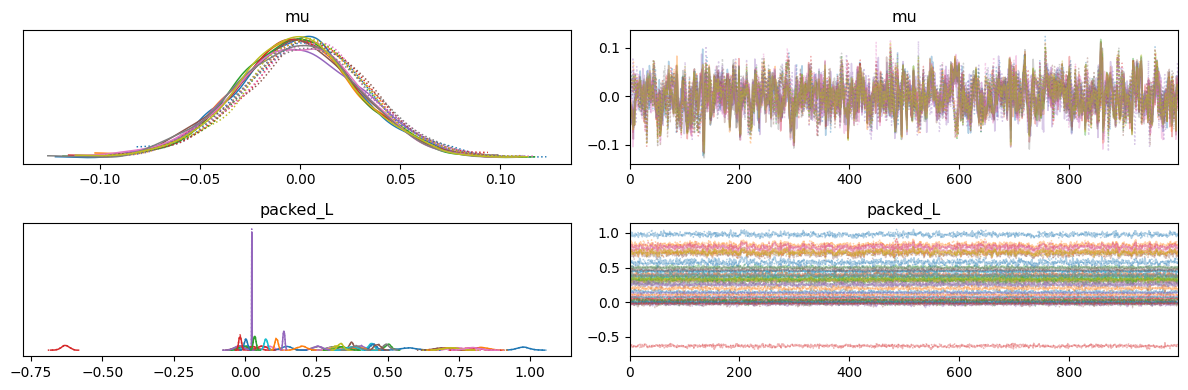

In [ ]:
# Trace plots
az.plot_trace(idata)
plt.tight_layout()